In [1]:
import os

import gymnasium as gym
import pybullet_envs_gymnasium
from stable_baselines3 import SAC
import numpy as np
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split

### Generate training data
Since we are training a sequence to sequence predictor which will take state as input and state as output, we will just need to generate sequences of states

In [2]:
env_name = "Walker2DBulletEnv-v0"
env = gym.make(env_name, render_mode='rgb_array')
model = SAC.load("./100k_steps_run.zip", env=env)

pybullet build time: May 12 2025 02:32:36


In [ ]:
total_timesteps = 10_000

states = np.zeros((total_timesteps, 16))
episode_ends = []

robot = env.unwrapped.robot
obs, info = env.reset()
for i in range(total_timesteps):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    state_o = robot.robot_body.current_orientation()
    state_j = np.array([j.get_state() for j in robot.ordered_joints]).flatten()
    states[i] = np.concat([state_o, state_j])
    if truncated or done:
        obs, info = env.reset()
        episode_ends.append(i)

episode_ends = np.array(episode_ends)

walker_a_dataset = {
    'state': states,
    'episode_ends': episode_ends
}

torch.save(walker_a_dataset, f'./walker_datasets/walker_bad_dict_{total_timesteps}_steps.pt')

argv[0]=
argv[0]=


In [3]:
def create_sample_indices(
        episode_ends,
        sequence_length,
        pad_before,
        pad_after
):
    indices = []
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after

        # range stops one idx before end
        for idx in range(min_start, max_start+1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx+start_idx)
            end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append([
                buffer_start_idx, buffer_end_idx,
                sample_start_idx, sample_end_idx])
    indices = np.array(indices)
    return indices


def sample_sequence(train_data, sequence_length,
                    buffer_start_idx, buffer_end_idx,
                    sample_start_idx, sample_end_idx):
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[buffer_start_idx:buffer_end_idx]
        data = sample
        if (sample_start_idx > 0) or (sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:],
                dtype=input_arr.dtype)
            if sample_start_idx > 0:
                data[:sample_start_idx] = sample[0]
            if sample_end_idx < sequence_length:
                data[sample_end_idx:] = sample[-1]
            data[sample_start_idx:sample_end_idx] = sample
        result[key] = data
    return result

class WalkerWalkingDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        dataset_path,
        pred_horizon,
        obs_horizon,
    ):
        dataset = torch.load(dataset_path, weights_only=False)
        # states = dataset['state']
        episode_ends = dataset['episode_ends']
        # print(episode_ends)

        indices = create_sample_indices(
            episode_ends=episode_ends,
            sequence_length=pred_horizon,
            # add padding such that each timestep in the dataset are seen
            pad_before=obs_horizon-1,
            pad_after=0
        )

        training_data = {'state': dataset['state'][:]}

        self.indices = indices
        self.train_data = training_data
        self.pred_horizon = pred_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        buffer_start_idx, buffer_end_idx, sample_start_idx, sample_end_idx = self.indices[idx]

        nsample = sample_sequence(
            train_data=self.train_data,
            sequence_length=self.pred_horizon,
            buffer_start_idx=buffer_start_idx,
            buffer_end_idx=buffer_end_idx,
            sample_start_idx=sample_start_idx,
            sample_end_idx=sample_end_idx
        )

        # nsample['state'] = nsample['state'][:self.obs_horizon,:]
        return nsample
        

In [ ]:
extracted_dataset_path = './walker_datasets/walker_bad_dict_10000_steps.pt'
obs_horizon = 10
pred_horizon = 20

walker_dataset = WalkerWalkingDataset(
    dataset_path=extracted_dataset_path,
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
)

train_size = int(0.8 * len(walker_dataset))
val_size = len(walker_dataset) - train_size 

train_dataset, val_dataset = random_split(walker_dataset, [train_size, val_size])

walker_train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=1,
    shuffle=True, # set this to False to visualize the dataset
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

walker_val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=1,
    shuffle=False, # set this to False to visualize the dataset
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)


# visualize data in batch
batch = next(iter(walker_val_dataloader))
print("batch['state'].shape:", batch['state'].shape)


batch['state'].shape: torch.Size([64, 20, 16])


### Visualize a squence

(0.0044371165801891654, 0.0)
(-0.09436906908366277, 0.0)
(-0.03077096391556551, 0.0)
(0.09579486718449232, 0.0)
(0.006947752355271869, 0.0)
(-0.029008095780355944, 0.0)


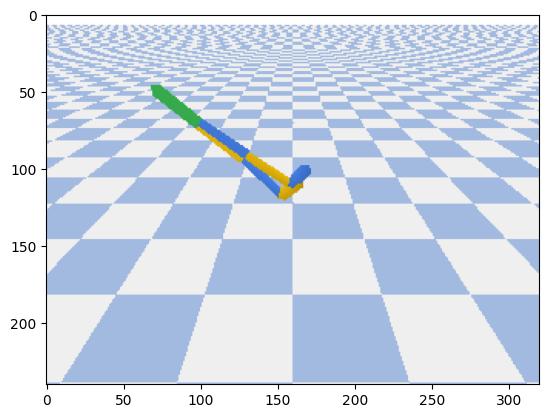

In [361]:
from IPython import display
torch.set_printoptions(precision=3, sci_mode=False)
import time

env_name = "Walker2DBulletEnv-v0"
env = gym.make(env_name, render_mode='rgb_array')

seq = batch['state'][20]

robot = env.unwrapped.robot
obs, info = env.reset()

robot.robot_body.reset_orientation(torch.Tensor([ 0.,    -0.404,  0.,     0.915]))

img = plt.imshow(env.render())
for state in seq:
    img.set_data(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    state_o = state[:4]
    state_j = state[4:].reshape(6,2)

    # robot.robot_body.reset_position([20.705,  0.,     0.962])
    # robot.robot_body.reset_position([0,0,0])
    # robot.robot_body.reset_orientation([ 0.,    -0.403,  0.,     0.915])

    # for j, (angle, vel) in zip(robot.ordered_joints, state_j):
    #     # j.set_state(angle, 0)
        # j.set_state(angle,vel)

    time.sleep(0.1)

joints = env.unwrapped.robot.ordered_joints

# print(env.unwrapped.robot_body.pose().rpy())
for j in joints:
    print(j.get_state())


### Train sequence prediction transformer

In [5]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x, start):
        """
        x: (batch, seq_len, dim)
        """
        device = x.device  # Get the device from the input tensor
        batch_size, seq_len, dim = x.size()  # batch_size, seq_len, dim
        half_dim = self.dim // 2  # We divide the dim into two halves for sin/cos

        # Create a position tensor from 0 to seq_len-1
        position = torch.arange(start, start+seq_len, device=device).float()  # (seq_len,)

        # Create div_term for sinusoidal encoding
        div_term = torch.exp(torch.arange(0, half_dim, 1, device=device).float() * -(math.log(10000.0) / half_dim))  # (half_dim,)

        # Calculate sinusoidal embeddings: sin and cos
        pe = position.unsqueeze(1) * div_term.unsqueeze(0)  # (seq_len, half_dim)
        pe = torch.cat((pe.sin(), pe.cos()), dim=-1)  # (seq_len, dim)

        # Expand to match batch size
        pe = pe.unsqueeze(0)  # (1, seq_len, dim)
        pe = pe.expand(batch_size, -1, -1)  # (batch_size, seq_len, dim)

        return pe.to(device)  # Make sure it's on the same device as x


class WalkerTransformer(nn.Module):
    def __init__(self, d_model=512, nhead=4, num_layers=4, dropout=0.1, betas=(0.9, 0.95), weight_decay=0.01):
        super().__init__()

        # Embedding layers for tool positions and T's position
        self.state_embed = nn.Linear(16, d_model)  # (x, y) → d_model

        # Position embedding
        self.pe = SinusoidalPosEmb(d_model)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead,dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output layer to predict next (x, y) positions
        self.fc_out = nn.Linear(d_model, 16)

    def forward(self, state_past, state_future=None):
      batch_size = state_past.shape[0]
      device = state_past.device

      # Encoder: Process past tool positions and T's position
      state_past_emb = self.state_embed(state_past[:,-1,:])  # (batch, d_model)
      state_past_emb = state_past_emb.unsqueeze(1) # (batch, 1, d_model)

      state_past_emb += self.pe(state_past_emb, 0)  # Add positional encoding
      state_past_emb = state_past_emb.permute(1, 0, 2)  # (1, batch, d_model)

      memory_input = state_past_emb
      memory = self.encoder(memory_input)


      # T's position (sequence)
    #   t_emb = self.t_embed(t_position[:,-1,:])  # (batch, t_seq_len, d_model), e.g., (batch, 1, d_model)
    #   t_emb = t_emb.unsqueeze(1)
    #   t_emb = t_emb.permute(1, 0, 2)  # (t_seq_len, batch, d_model), e.g., (1, batch, d_model)

    #   memory_input = t_emb # (1, batch, d_model)
    #   memory = self.encoder(memory_input)  # (1, batch, d_model)

      if state_future is not None:
          # Training mode: Use teacher forcing with the ground truth sequence
          state_future_emb = self.state_embed(state_future[:, :7, :])  # (batch, 7, d_model)
          state_future_emb += self.pe(state_future_emb,1)
          state_future_emb = state_future_emb.permute(1, 0, 2)  # (7, batch, d_model)
          seq_len = state_future_emb.shape[0]  # 7
          causal_mask = torch.triu(torch.ones(seq_len+1, seq_len+1, device=device), diagonal=1).bool() # tool_past + tool_future

          path = torch.cat([state_past_emb, state_future_emb], dim=0)
        #   path = state_future_emb

          output = self.decoder(path, memory.expand(seq_len+1, -1, -1), tgt_mask=causal_mask)
          output = self.fc_out(output).permute(1, 0, 2)  # (batch, 16, 2)
          return output[:,:,:]
      else:
          # Inference mode: Generate autoregressively
          current_pos = state_past[:, -1:, :]  # Start with the last tool position (batch, 1, 2)
          state_future_emb = self.state_embed(current_pos)  # (batch, 1, d_model)
          state_future_emb += self.pe(state_future_emb,0)
          state_future_emb = state_future_emb.permute(1, 0, 2)  # (1, batch, d_model)
          generated = []

          for step in range(8):  # Generate 8 steps
              seq_len = state_future_emb.shape[0]  # Current sequence length
              # Create a causal mask: upper triangle is blocked
              causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool().to(device)
              # Pass the sequence and mask to the decoder

              output = self.decoder(state_future_emb, memory.expand(seq_len, -1, -1), tgt_mask=causal_mask) # (seq_len,batch,d_model)
              # Use the last output to predict the next token
              next_pos = self.fc_out(output[-1]).unsqueeze(0) # (1,batch,d_model)
              generated.append(next_pos) # (seq_len-1,batch,d_model)
              # Append the new token to the sequence (with embeddings and positional encoding)
              next_emb = self.state_embed(next_pos.permute(1, 0, 2)) # (batch, 1, d_model)
              next_emb += self.pe(next_emb,seq_len)[:, :1, :]  # Positional encoding for current step
              state_future_emb = torch.cat((state_future_emb, next_emb.permute(1,0,2)), dim=0) # (seq_len, batch, d_model)

          # Combine all generated steps
          generated = torch.cat(generated, dim=0).permute(1, 0, 2)  # (batch, 16, 2)
          return generated[:,:,:]

device = "cuda" if torch.cuda.is_available() else "cpu"
model = WalkerTransformer().to(device)
epoch = 0

/home/ronan/miniforge3/envs/exoskeleton/lib/python3.13/site-packages/torch/nn/modules/transformer.py:386: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

t_losses = []
v_losses = []

scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=10e-7)  # T_max is the number of iterations for the decay
epoch = 0
for epoch in range(epoch, epoch + 100):

    # Training phase
    model.train()  # Set model to training mode
    train_loss = 0.0

    with tqdm(walker_train_dataloader, desc='Training Batch', leave=False) as tepoch:
        for batch in tepoch:
            tool_past = batch['state'][:,:4,:].float().to(device)  # the last two actions
            tool_future = batch['state'][:,4:,:].float().to(device)  # the future actions

            # Training step
            optimizer.zero_grad()
            pred_future = model(tool_past, tool_future)
            loss = criterion(pred_future[:, :4, :], tool_future[:, :4, :])
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

    # Average training loss
    avg_train_loss = train_loss / len(walker_train_dataloader)

    # Validation phase
    model.eval()  # Set model to evaluatSion mode
    val_loss = 0.0

    with torch.no_grad():  # No gradients needed for validation
        for batch in walker_val_dataloader:
            tool_past = batch['state'][:,:4,:].float().to(device)  # the last two actions
            tool_future = batch['state'][:,4:,:].float().to(device)  # the future actions

            # Validation step
            pred_future = model(tool_past, tool_future)
            loss = criterion(pred_future[:, :4, :], tool_future[:, :4, :])
            val_loss += loss.item()

    avg_val_loss = val_loss / len(walker_val_dataloader)     # Average validation loss

    scheduler.step() # Step the scheduler 

    # Print stats for the epoch
    print(f"Epoch: {epoch} | Train Loss: {avg_train_loss * 1000:.4f} | Validation Loss: {avg_val_loss * 1000:.4f}")
    t_losses.append(avg_train_loss * 1000)
    v_losses.append(avg_val_loss)

    # Print current learning rate
    for param_group in optimizer.param_groups:
        print(f"Current Learning Rate: {param_group['lr']:.8f}")

Training Batch:   0%|          | 0/610 [00:00<?, ?it/s]

/tmp/ipykernel_26419/1071558864.py:31: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /home/ronan/Documents/github/pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  train_loss += loss.item()


Epoch: 0 | Train Loss: 149.1711 | Validation Loss: 115.4230
Current Learning Rate: 0.00009939


Training Batch:   0%|          | 0/610 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 112.1708 | Validation Loss: 115.5241
Current Learning Rate: 0.00009758


Training Batch:   0%|          | 0/610 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 104.4260 | Validation Loss: 105.2201
Current Learning Rate: 0.00009460


Training Batch:   0%|          | 0/610 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), "./walker_predictor_bad_walker.pt")

[]

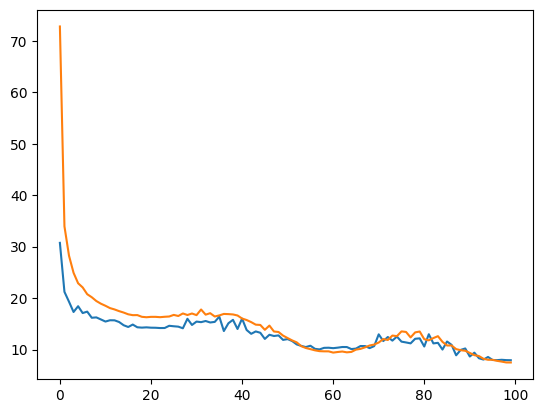

In [ ]:
plt.figure()
plt.plot(np.arange(len(v_losses)), v_losses)
plt.plot(np.arange(len(t_losses)), t_losses)
plt.plot()

[]
[]
[]


<Axes: >

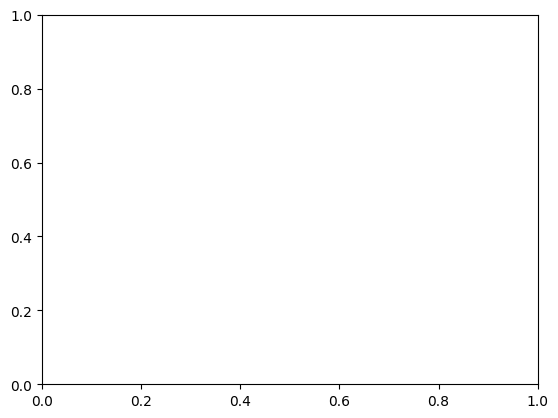

In [ ]:
v_losses_good_walker = v_losses
t_losses_good_walker = t_losses

print(v_losses_good_walker)
print(t_losses_good_walker)

print(v_losses)


# Tutorial stuff
Following this:
https://medium.com/correll-lab/robotic-behavior-cloning-i-auto-regressive-transformers-a7be623f4291

for this, installed gdown and zarr, which in turn installed

PySocks, soupsieve, beautifulsoup4, numcodecs, donfig, crc32c

In [1]:
import os # to deal with files
import gdown # to download from google drive
import zipfile # to unzip

# download demonstration data from Google Drive
dataset_path = "pusht_cchi_v7_replay.zarr.zip"
extracted_dataset_path = "pusht_cchi_v7_replay.zarr"  # Path to extracted dataset

if not os.path.isfile(dataset_path):
    id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    gdown.download(id=id, output=dataset_path, quiet=False)

# Extract the dataset if it hasn't been extracted yet
if not os.path.isdir(extracted_dataset_path):
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dataset_path)

Downloading...
From: https://drive.google.com/uc?id=1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t
To: /home/ronan/Documents/github/exoskeleton/pusht_cchi_v7_replay.zarr.zip
100%|██████████| 31.1M/31.1M [00:00<00:00, 88.7MB/s]


In [144]:
import zarr # to load the dataset
import numpy as np
import torch

def create_sample_indices(
        episode_ends:np.ndarray, sequence_length:int,
        pad_before: int=0, pad_after: int=0):
    indices = list()
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i-1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after

        # range stops one idx before end
        for idx in range(min_start, max_start+1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx+sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx+start_idx)
            end_offset = (idx+sequence_length+start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append([
                buffer_start_idx, buffer_end_idx,
                sample_start_idx, sample_end_idx])
    indices = np.array(indices)
    return indices


def sample_sequence(train_data, sequence_length,
                    buffer_start_idx, buffer_end_idx,
                    sample_start_idx, sample_end_idx):
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[buffer_start_idx:buffer_end_idx]
        data = sample
        if (sample_start_idx > 0) or (sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:],
                dtype=input_arr.dtype)
            if sample_start_idx > 0:
                data[:sample_start_idx] = sample[0]
            if sample_end_idx < sequence_length:
                data[sample_end_idx:] = sample[-1]
            data[sample_start_idx:sample_end_idx] = sample
        result[key] = data
    return result

# normalize data
def get_data_stats(data):
    data = data.reshape(-1,data.shape[-1])
    stats = {
        'min': np.min(data, axis=0),
        'max': np.max(data, axis=0)
    }
    return stats

def normalize_data(data, stats):
    # nomalize to [0,1]
    ndata = (data - stats['min']) / (stats['max'] - stats['min'])
    # normalize to [-1, 1]
    ndata = ndata * 2 - 1
    return ndata

def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2
    data = ndata * (stats['max'] - stats['min']) + stats['min']
    return data

# dataset
class PushTStateDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path,
                 pred_horizon, obs_horizon, action_horizon):

        # read from zarr dataset
        dataset_root = zarr.open(dataset_path, mode='r')
        # All demonstration episodes are concatinated in the first dimension N
        train_data = {
            # (N, action_dim)
            'action': dataset_root['data']['action'][:],
            # (N, obs_dim)
            'obs': dataset_root['data']['state'][:]
        }
        # Marks one-past the last index for each episode
        episode_ends = dataset_root['meta']['episode_ends'][:]

        # compute start and end of each state-action sequence
        # also handles padding
        indices = create_sample_indices(
            episode_ends=episode_ends,
            sequence_length=pred_horizon,
            # add padding such that each timestep in the dataset are seen
            pad_before=obs_horizon-1,
            pad_after=action_horizon-1)

        # compute statistics and normalized data to [-1,1]
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        self.indices = indices
        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        # all possible segments of the dataset
        return len(self.indices)

    def __getitem__(self, idx):
        # get the start/end indices for this datapoint
        buffer_start_idx, buffer_end_idx, \
            sample_start_idx, sample_end_idx = self.indices[idx]

        # get nomralized data using these indices
        nsample = sample_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            buffer_start_idx=buffer_start_idx,
            buffer_end_idx=buffer_end_idx,
            sample_start_idx=sample_start_idx,
            sample_end_idx=sample_end_idx
        )

        # discard unused observations
        nsample['obs'] = nsample['obs'][:self.obs_horizon,:]
        return nsample

In [150]:
from torch.utils.data import random_split

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
dataset = PushTStateDataset(
    dataset_path="pusht_cchi_v7_replay.zarr",
    pred_horizon=pred_horizon,
    obs_horizon=obs_horizon,
    action_horizon=action_horizon
)
# save training data statistics (min, max) for each dim
stats = dataset.stats

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size  # Ensure all samples are used

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create dataloaders
dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=1,
    shuffle=True, # set this to False to visualize the dataset
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=1,
    shuffle=False, # set this to False to visualize the dataset
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)


# visualize data in batch
batch = next(iter(val_dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

batch['obs'].shape: torch.Size([64, 2, 5])
batch['action'].shape torch.Size([64, 16, 2])


In [185]:
# tool_past = batch['obs']
# t_position = torch.cat((batch["obs"][...,:-1],
#                         torch.sin(batch["obs"][...,-1]).unsqueeze(-1),
#                         torch.cos(batch["obs"][...,-1]).unsqueeze(-1)),
#                         dim=-1)[:,:,2:]
# tool_future = batch['action']

# print(f'{tool_past.shape=}')
# print(f'{t_position.shape=}')
# print(f'{tool_future.shape=}')

print(dataset[0].keys())
print(dataset[0]['action'].shape)
print(dataset[0]['obs'].shape)

dict_keys(['action', 'obs'])
(16, 2)
(2, 5)


In [29]:
print(list(dataset_root.keys()))
print(list(dataset_root['data'].keys()))
print(list(dataset_root['meta'].keys()))

print(f'{dataset_root['data']['state'] = }')
print(f'{dataset_root['data']['action'] = }')
print(f'{dataset_root['meta']['episode_ends'] = }') # 206 episode ends
print(f'{dataset_root['data']['img'] = }')

print(f'{dataset_root['meta']['episode_ends']}')

['meta', 'data']
['action', 'img', 'keypoint', 'state', 'n_contacts']
['episode_ends']
dataset_root['data']['state'] = <Array file://pusht_cchi_v7_replay.zarr/data/state shape=(25650, 5) dtype=float32>
dataset_root['data']['action'] = <Array file://pusht_cchi_v7_replay.zarr/data/action shape=(25650, 2) dtype=float32>
dataset_root['meta']['episode_ends'] = <Array file://pusht_cchi_v7_replay.zarr/meta/episode_ends shape=(206,) dtype=int64>
dataset_root['data']['img'] = <Array file://pusht_cchi_v7_replay.zarr/data/img shape=(25650, 96, 96, 3) dtype=float32>
<Array file://pusht_cchi_v7_replay.zarr/meta/episode_ends shape=(206,) dtype=int64>
